In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/water-potability/water_potability.csv


In [2]:
df= pd.read_csv('../input/water-potability/water_potability.csv')
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [3]:
features_with_nan = [feature for feature in df.columns if df[feature].isnull().sum()>0]
features_with_nan

['ph', 'Sulfate', 'Trihalomethanes']

In [4]:
df.dtypes

ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object

In [5]:
df['Trihalomethanes'].isna().sum()

162

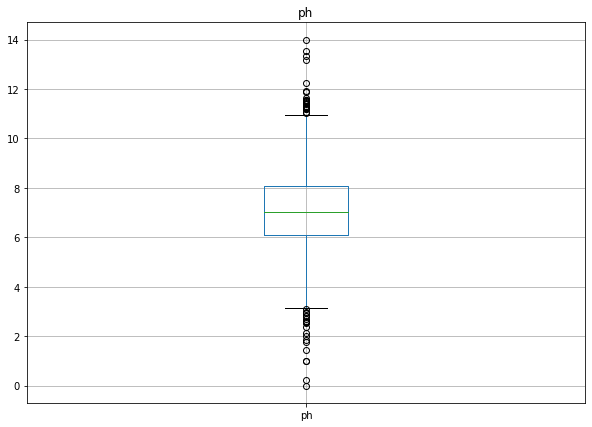

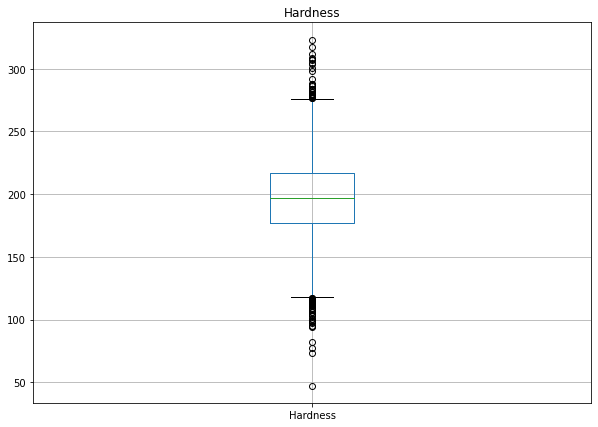

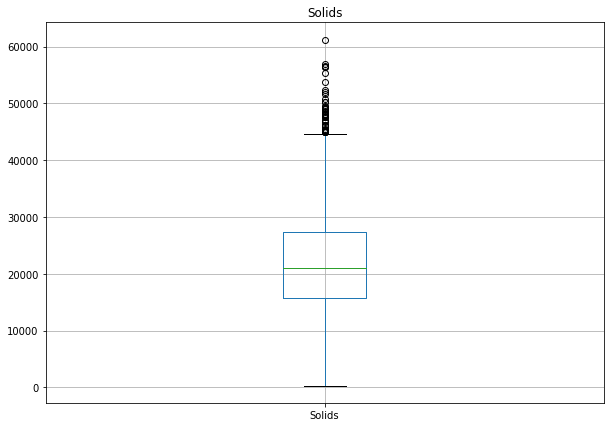

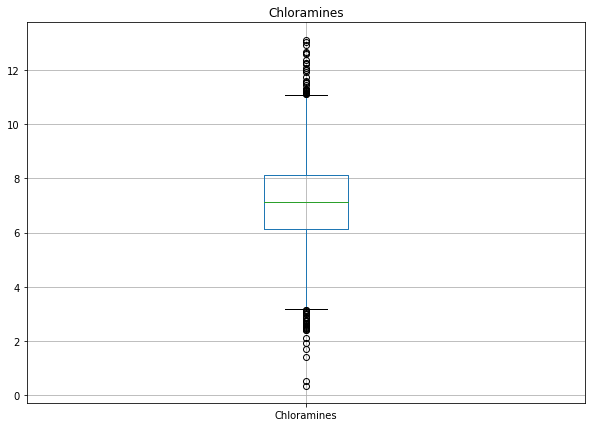

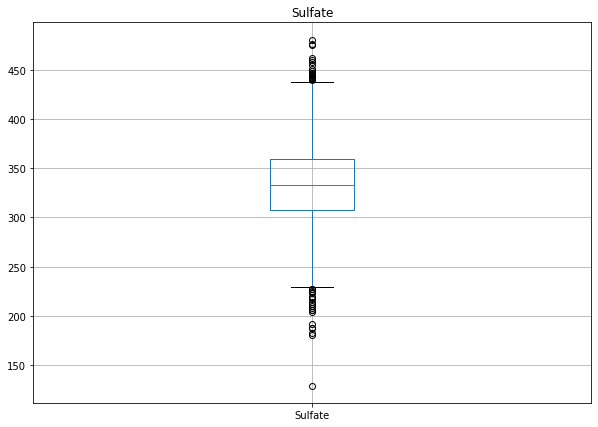

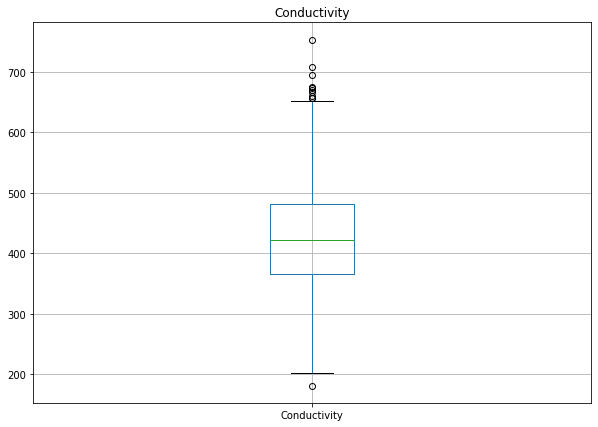

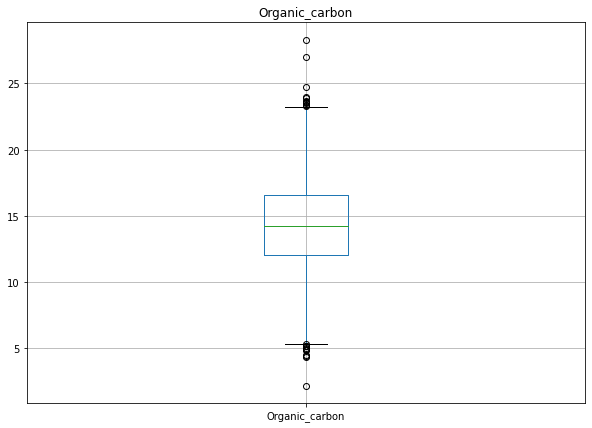

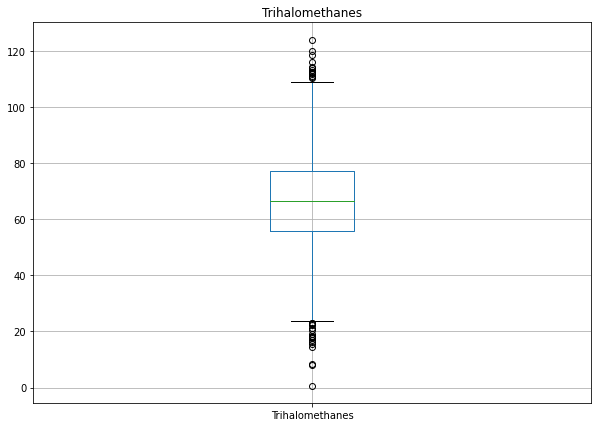

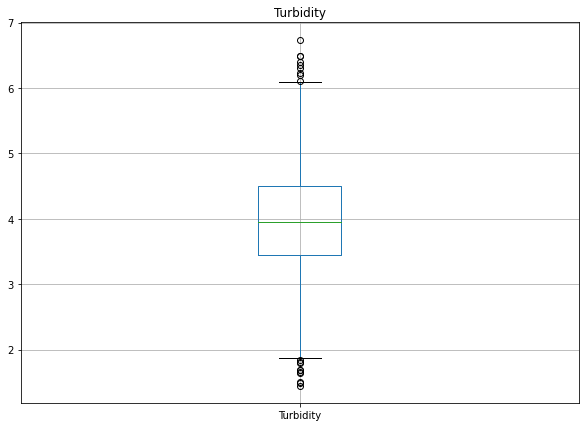

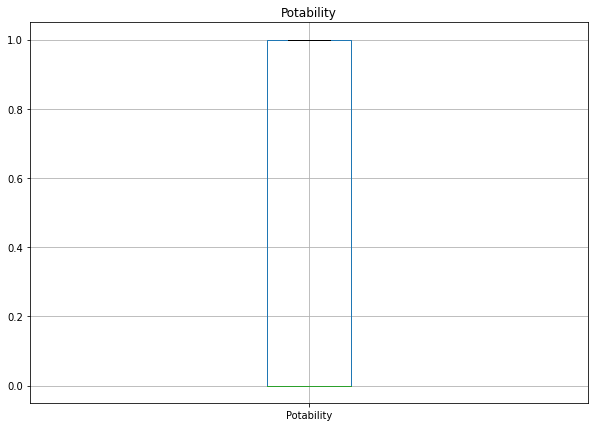

In [6]:
for feature in df.columns:
    fig = plt.figure(figsize =(10, 7))
    df.boxplot(feature)
    plt.title(feature)
    plt.show()

In [7]:
df['Sulfate'].describe()

count    2495.000000
mean      333.775777
std        41.416840
min       129.000000
25%       307.699498
50%       333.073546
75%       359.950170
max       481.030642
Name: Sulfate, dtype: float64

In [8]:
df.shape

(3276, 10)

In [9]:
df = df.dropna()

In [10]:
df.shape

(2011, 10)

In [11]:
df['Potability'].value_counts()

0    1200
1     811
Name: Potability, dtype: int64

In [12]:
class_0 = df[df['Potability']==0]
class_1 = df[df['Potability']==1]
from sklearn.utils import resample
df_minority_resampled = resample(class_1,n_samples=1200,replace=True) 
df = pd.concat([class_0,df_minority_resampled])
df['Potability'].value_counts()

0    1200
1    1200
Name: Potability, dtype: int64

In [13]:
X = df.drop('Potability', axis = 'columns')
y = df['Potability']

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state=42)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X_train,y_train)

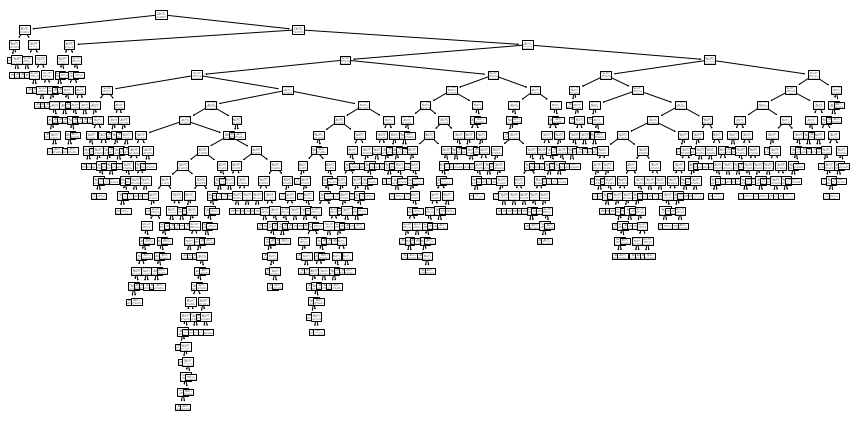

In [15]:
plt.figure(figsize = (15,7.5))
plot_tree(clf_dt,
    max_depth=None,
    feature_names=None,
    class_names=['Not to drink','Can Drink'],
    label='all',
    filled=False,
    impurity=True,
    node_ids=False,
    proportion=False,
    rotate='deprecated',
    rounded=False,
    precision=3,
    ax=None,
    fontsize=None,)
plt.show()

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test,clf_dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.70      0.73       115
           1       0.74      0.80      0.77       125

    accuracy                           0.75       240
   macro avg       0.75      0.75      0.75       240
weighted avg       0.75      0.75      0.75       240



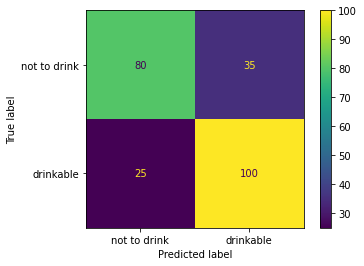

In [17]:
plot_confusion_matrix(clf_dt, X_test,y_test, display_labels=['not to drink','drinkable'])

In [18]:
from sklearn.model_selection import cross_val_score
path = clf_dt.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

alpha_loop_values = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt,X_train,y_train,cv=5)
    alpha_loop_values.append([ccp_alpha,np.mean(scores)])

<AxesSubplot:xlabel='ccp_alpha'>

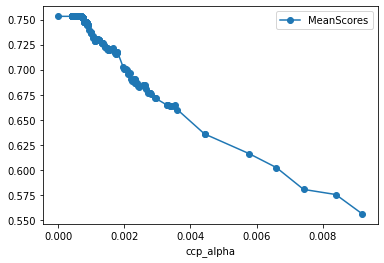

In [19]:
alpha_df = pd.DataFrame(alpha_loop_values,columns= ['ccp_alpha', 'MeanScores'])

alpha_df.plot('ccp_alpha','MeanScores', marker='o')
 

In [20]:
alpha_df[alpha_df['MeanScores']>0.700]

,ccp_alpha,MeanScores
0,0.000000,0.753241
1,0.000424,0.753241
2,0.000424,0.753241
3,0.000424,0.753241
4,0.000430,0.753241
...,...,...
151,0.001792,0.718056
152,0.001970,0.702315
153,0.002002,0.700926
154,0.002022,0.700463


In [21]:
clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=0)
clf_dt = clf_dt.fit(X_train,y_train)

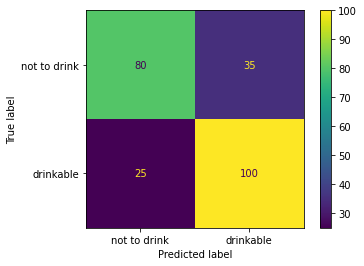

In [22]:
plot_confusion_matrix(clf_dt, X_test,y_test, display_labels=['not to drink','drinkable'])

In [23]:
print(classification_report(y_test,clf_dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.70      0.73       115
           1       0.74      0.80      0.77       125

    accuracy                           0.75       240
   macro avg       0.75      0.75      0.75       240
weighted avg       0.75      0.75      0.75       240



In [24]:
clf_dt.score(X_test,y_test)

0.75

In [25]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
###new
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [26]:
clf_rf = GridSearchCV(RandomForestClassifier(),{
    'n_estimators' : [100,200,350,500,800,850],
    'min_samples_leaf' : [2,10,30]
}, cv=5)
clf_rf.fit(X_train_std,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': [2, 10, 30],
                         'n_estimators': [100, 200, 350, 500, 800, 850]})

In [27]:
clf_rf.best_params_

{'min_samples_leaf': 2, 'n_estimators': 500}

In [28]:
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(min_samples_leaf=2,n_estimators=850)
rf.fit(X_train_std,y_train)
print(classification_report(y_test, rf.predict(X_test_std)))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79       115
           1       0.82      0.77      0.79       125

    accuracy                           0.79       240
   macro avg       0.79      0.79      0.79       240
weighted avg       0.79      0.79      0.79       240



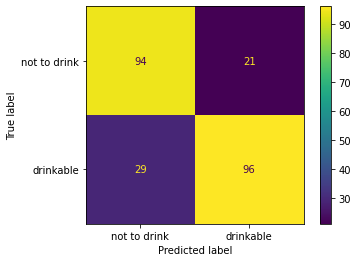

In [29]:
plot_confusion_matrix(rf, X_test_std,y_test, display_labels=['not to drink','drinkable'])

In [33]:
from sklearn.svm import SVC
clf_SVC = SVC()
clf_SVC.fit(X_train_std,y_train)

SVC()

In [34]:
print(classification_report(y_test, clf_SVC.predict(X_test_std)))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74       115
           1       0.77      0.69      0.73       125

    accuracy                           0.73       240
   macro avg       0.74      0.74      0.73       240
weighted avg       0.74      0.73      0.73       240

